In [1]:
import tensorflow as tf 
from tensorflow.keras import backend, regularizers, initializers, models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import plot_model

In [2]:
cifar100 = keras.datasets.cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train:", len(x_train), "x_test:", len(x_test))

169017344/169001437 [==============================] - 11s 0us/step
x_train: 50000 x_test: 10000


In [3]:
def plain_conv_block(input_tensor,
                     filters,
                     stage,
                     block,
                     strides=(2,2),
                     bn_decay=0.9,
                     bn_epsilon=1e-5):
  
  filters1,filters2,filters3=filters

  if backend.image_data_format()=='channels_last':
    bn_axis=3
  else:
    bn_axis=1

  conv_name = 'res'+str(stage)+block+'_branch'
  bn_name = 'bn'+str(stage)+block+'_branch'

  x = layers.Conv2D(filters1,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(x)
  
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,(3,3),strides=strides,padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2c')(x)

  x = layers.Activation('relu')(x)

  return x

In [4]:
def plain_identity_block(input_tensor,
                         filters,
                         stage,
                         block,
                         bn_decay=0.9,
                         bn_epsilon=1e-5):
  
  filters1,filters2,filters3=filters

  if backend.image_data_format()=='channels_last':
    bn_axis=3
  else:
    bn_axis=1

  id_name='res'+str(stage)+block+'_barnch'
  bn_name='bn'+str(stage)+block+'_barnch'

  x = layers.Conv2D(filters1,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(x)
  
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,(3,3),padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2c')(x)

  x = layers.Activation('relu')(x)

  return x

In [5]:
def plain_101(num_classes,
              batch_size=None,
              bn_decay=0.9,
              bn_epsilon=1e-5):
  
  input_shape = (32,32,3)
  input=layers.Input(shape=input_shape, batch_size=batch_size)

  if backend.image_data_format == 'channels_last':
    bn_axis=3
    x = input
  else:
    x = layers.Permute((3, 1, 2))(input)
    bn_axis=1

  config_block=dict(bn_decay=bn_decay,
               bn_epsilon=bn_epsilon)
  
  x = layers.ZeroPadding2D(padding=(3,3),name='conv_pad')(x)
  x = layers.Conv2D(64,(7,7),strides=(2,2),padding='valid',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name='conv1')(x)
  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name='bn1')(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3,3),strides=(2,2),padding='same')(x)

  x = plain_conv_block(x,[64,64,256],stage=2,block='a',strides=(1,1),**config_block)
  x = plain_identity_block(x,[64,64,256],stage=2,block='b',**config_block)
  x = plain_identity_block(x,[64,64,256],stage=2,block='c',**config_block)

  x = plain_conv_block(x,[128,128,512],stage=3,block='a',**config_block)
  x = plain_identity_block(x,[128,128,512],stage=3,block='b',**config_block)
  x = plain_identity_block(x,[128,128,512],stage=3,block='c',**config_block)
  x = plain_identity_block(x,[128,128,512],stage=3,block='d',**config_block)

  x = plain_conv_block(x,[256,256,1024],stage=4,block='a',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='b',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='c',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='d',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='e',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='f',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='g',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='h',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='i',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='j',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='k',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='l',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='m',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='n',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='o',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='p',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='q',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='r',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='t',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='u',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='v',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='w',**config_block)
  x = plain_identity_block(x,[256,256,1024],stage=4,block='x',**config_block)

  x = plain_conv_block(x,[512,512,2048],stage=5,block='a',**config_block)
  x = plain_identity_block(x,[512,512,2048],stage=5,block='b',**config_block)
  x = plain_identity_block(x,[512,512,2048],stage=5,block='c',**config_block)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(num_classes,
                   kernel_initializer=initializers.RandomNormal(stddev=0.01),
                   kernel_regularizer=keras.regularizers.l2(1e-4),
                   bias_regularizer=keras.regularizers.l2(1e-4),
                   name='fc1000')(x)
  x = layers.Activation('softmax',dtype='float32')(x)

  return models.Model(input,x,name='Plain101')

In [6]:
plain101 = plain_101(num_classes=100)
plain101.summary()

Model: "Plain101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 permute (Permute)           (None, 3, 32, 32)         0         
                                                                 
 conv_pad (ZeroPadding2D)    (None, 9, 38, 32)         0         
                                                                 
 conv1 (Conv2D)              (None, 2, 16, 64)         100352    
                                                                 
 bn1 (BatchNormalization)    (None, 2, 16, 64)         8         
                                                                 
 activation (Activation)     (None, 2, 16, 64)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 8, 64)         0  

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.965524 to fit



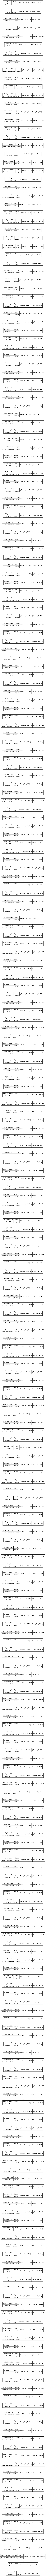

In [7]:
plot_model(plain101,show_shapes=True)

In [8]:
plain101.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_plain101 = plain101.fit(x_train, y_train, epochs=100)

Epoch 1/100
1563/1563 [==============================] - 105s 56ms/step - loss: 794228352.0000 - accuracy: 0.0102
Epoch 2/100
1563/1563 [==============================] - 86s 55ms/step - loss: 789786048.0000 - accuracy: 0.0098
Epoch 3/100
1563/1563 [==============================] - 87s 56ms/step - loss: 784865152.0000 - accuracy: 0.0096
Epoch 4/100
1563/1563 [==============================] - 87s 56ms/step - loss: 779974464.0000 - accuracy: 0.0094
Epoch 5/100
1563/1563 [==============================] - 87s 56ms/step - loss: 775114688.0000 - accuracy: 0.0106
Epoch 6/100
1563/1563 [==============================] - 88s 56ms/step - loss: 770285504.0000 - accuracy: 0.0096
Epoch 7/100
1563/1563 [==============================] - 87s 56ms/step - loss: 765485824.0000 - accuracy: 0.0096
Epoch 8/100
1563/1563 [==============================] - 87s 56ms/step - loss: 760716224.0000 - accuracy: 0.0095
Epoch 9/100
1563/1563 [==============================] - 87s 56ms/step - loss: 755977152.0000 -

In [9]:
def conv_block(input_tensor,
                     filters,
                     stage,
                     block,
                     strides=(2,2),
                     bn_decay=0.9,
                     bn_epsilon=1e-5):
  
  filters1,filters2,filters3=filters

  if backend.image_data_format()=='channels_last':
    bn_axis=3
  else:
    bn_axis=1

  conv_name = 'res'+str(stage)+block+'_branch'
  bn_name = 'bn'+str(stage)+block+'_branch'

  x = layers.Conv2D(filters1,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(x)
  
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,(3,3),strides=strides,padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2c')(x)

  shortcut = layers.Conv2D(filters3,(1,1),strides=strides,use_bias=False,
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(1e-4),
                           name=conv_name+'1')(input_tensor)

  shortcut = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'1')(shortcut)

  x = layers.add([shortcut,x])
  
  x = layers.Activation('relu')(x)

  return x

In [10]:
def identity_block(input_tensor,
                         filters,
                         stage,
                         block,
                         bn_decay=0.9,
                         bn_epsilon=1e-5):
  
  filters1,filters2,filters3=filters

  if backend.image_data_format()=='channels_last':
    bn_axis=3
  else:
    bn_axis=1

  id_name='res'+str(stage)+block+'_barnch'
  bn_name='bn'+str(stage)+block+'_barnch'

  x = layers.Conv2D(filters1,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(x)
  
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,(3,3),padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2c')(x)

  x = layers.add([x,input_tensor])

  x = layers.Activation('relu')(x)

  return x

In [11]:
def ResNet_101(num_classes,
               batch_size=None,
               bn_decay=0.9,
               bn_epsilon=1e-5):
  
  input_shape = (32,32,3)
  input=layers.Input(shape=input_shape, batch_size=batch_size)

  if backend.image_data_format == 'channels_last':
    bn_axis=3
    x = input
  else:
    x = layers.Permute((3, 1, 2))(input)
    bn_axis=1

  config_block=dict(bn_decay=bn_decay,
               bn_epsilon=bn_epsilon)
  
  x = layers.ZeroPadding2D(padding=(3,3),name='conv_pad')(x)
  x = layers.Conv2D(64,(7,7),strides=(2,2),padding='valid',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name='conv1')(x)
  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name='bn1')(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3,3),strides=(2,2),padding='same')(x)

  x = conv_block(x,[64,64,256],stage=2,block='a',strides=(1,1),**config_block)
  x = identity_block(x,[64,64,256],stage=2,block='b',**config_block)
  x = identity_block(x,[64,64,256],stage=2,block='c',**config_block)

  x = conv_block(x,[128,128,512],stage=3,block='a',**config_block)
  x = identity_block(x,[128,128,512],stage=3,block='b',**config_block)
  x = identity_block(x,[128,128,512],stage=3,block='c',**config_block)
  x = identity_block(x,[128,128,512],stage=3,block='d',**config_block)

  x = conv_block(x,[256,256,1024],stage=4,block='a',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='b',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='c',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='d',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='e',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='f',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='g',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='h',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='i',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='j',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='k',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='l',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='m',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='n',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='o',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='p',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='q',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='r',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='t',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='u',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='v',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='w',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='x',**config_block)

  x = conv_block(x,[512,512,2048],stage=5,block='a',**config_block)
  x = identity_block(x,[512,512,2048],stage=5,block='b',**config_block)
  x = identity_block(x,[512,512,2048],stage=5,block='c',**config_block)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(num_classes,
                   kernel_initializer=initializers.RandomNormal(stddev=0.01),
                   kernel_regularizer=keras.regularizers.l2(1e-4),
                   bias_regularizer=keras.regularizers.l2(1e-4),
                   name='fc1000')(x)
  x = layers.Activation('softmax',dtype='float32')(x)

  return models.Model(input,x,name='Plain101')

In [12]:
resnet101=ResNet_101(num_classes=100)
resnet101.summary()

Model: "Plain101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 3, 32, 32)    0           ['input_2[0][0]']                
                                                                                                  
 conv_pad (ZeroPadding2D)       (None, 9, 38, 32)    0           ['permute_1[0][0]']              
                                                                                                  
 conv1 (Conv2D)                 (None, 2, 16, 64)    100352      ['conv_pad[0][0]']               
                                                                                           

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.871718 to fit



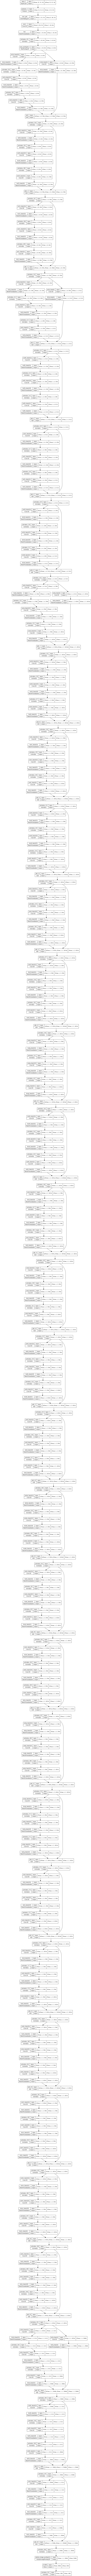

In [13]:
plot_model(resnet101,show_shapes=True)

In [14]:
resnet101.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_resnet101 = resnet101.fit(x_train, y_train, epochs=100)

Epoch 1/100
1563/1563 [==============================] - 101s 59ms/step - loss: 15.1720 - accuracy: 0.0373
Epoch 2/100
1563/1563 [==============================] - 92s 59ms/step - loss: 14.6861 - accuracy: 0.0763
Epoch 3/100
1563/1563 [==============================] - 92s 59ms/step - loss: 14.4203 - accuracy: 0.1018
Epoch 4/100
1563/1563 [==============================] - 92s 59ms/step - loss: 14.2053 - accuracy: 0.1263
Epoch 5/100
1563/1563 [==============================] - 92s 59ms/step - loss: 14.0186 - accuracy: 0.1449
Epoch 6/100
1563/1563 [==============================] - 92s 59ms/step - loss: 13.8636 - accuracy: 0.1614
Epoch 7/100
1563/1563 [==============================] - 92s 59ms/step - loss: 13.7146 - accuracy: 0.1775
Epoch 8/100
1563/1563 [==============================] - 92s 59ms/step - loss: 13.5773 - accuracy: 0.1876
Epoch 9/100
1563/1563 [==============================] - 92s 59ms/step - loss: 13.4486 - accuracy: 0.1985
Epoch 10/100
1563/1563 [=====================

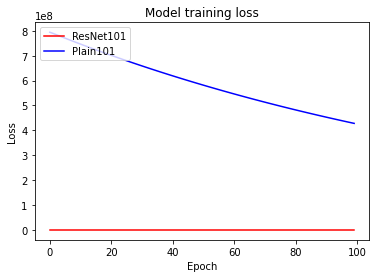

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_resnet101.history['loss'], 'r')
plt.plot(history_plain101.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet101','Plain101'], loc='upper left')
plt.show()

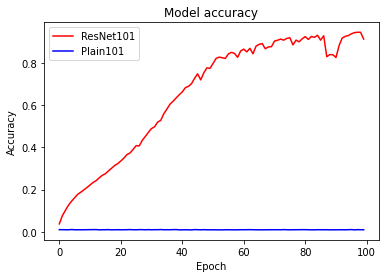

In [16]:
plt.plot(history_resnet101.history['accuracy'], 'r')
plt.plot(history_plain101.history['accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet101', 'Plain101'], loc='upper left')
plt.show()